L'objectif de cette partie est d'extraire les zones à risques d'inodation à partir du fichier des Territoires à Risques important d'Inondation (TRI), millésime 2020 sous format shapefile, disponible au téléchargement au niveau national (première partie) puis régionale (deuxième partie) à l'adresse Url suivante : https://www.georisques.gouv.fr/donnees/bases-de-donnees/zonages-inondation-rapportage-2020

Ce fichier comprend les données d'inondabilité du territoire français identifiés par la directive Inondation à partir de 2007. 


In [1]:
# Importation du package Cartiflette 
!pip install py7zr geopandas openpyxl tqdm s3fs
!pip install PyYAML xlrd
!pip install git+https://github.com/inseefrlab/cartiflette

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 95.6 MB/s eta 0:00:00
  Cloning https://github.com/inseefrlab/cartiflette to /tmp/pip-req-build-7ei09eg8
  Running command git clone --filter=blob:none --quiet https://github.com/inseefrlab/cartiflette /tmp/pip-req-build-7ei09eg8
  Resolved https://github.com/inseefrlab/cartiflette to commit f6b0c5d049bd6dcae7b437bd931957371da24278
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 63.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 73.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 79.2 MB/s eta 0:00:00
  Created wheel for cartiflette: filename=cartiflette-0.0.2-py3-none-any.whl size=56573 sha256=7e59f26a71f86d2e94fde43e66cedc1ab47120e738ca086278e0ae3

/tmp/ipykernel_31289/2127001253.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  (gdf.geometry.centroid.y >= 41) & (gdf.geometry.centroid.y <= 51) &  # Filtrer par latitude
/tmp/ipykernel_31289/2127001253.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  (gdf.geometry.centroid.x >= -5) & (gdf.geometry.centroid.x <= 10)   # Filtrer par longitude


INSEE_COM
13004    153
13096    131
30276    125
30341    111
30003     86
        ... 
76740      1
76517      1
76453      1
76123      1
76366      1
Name: count, Length: 4939, dtype: int64


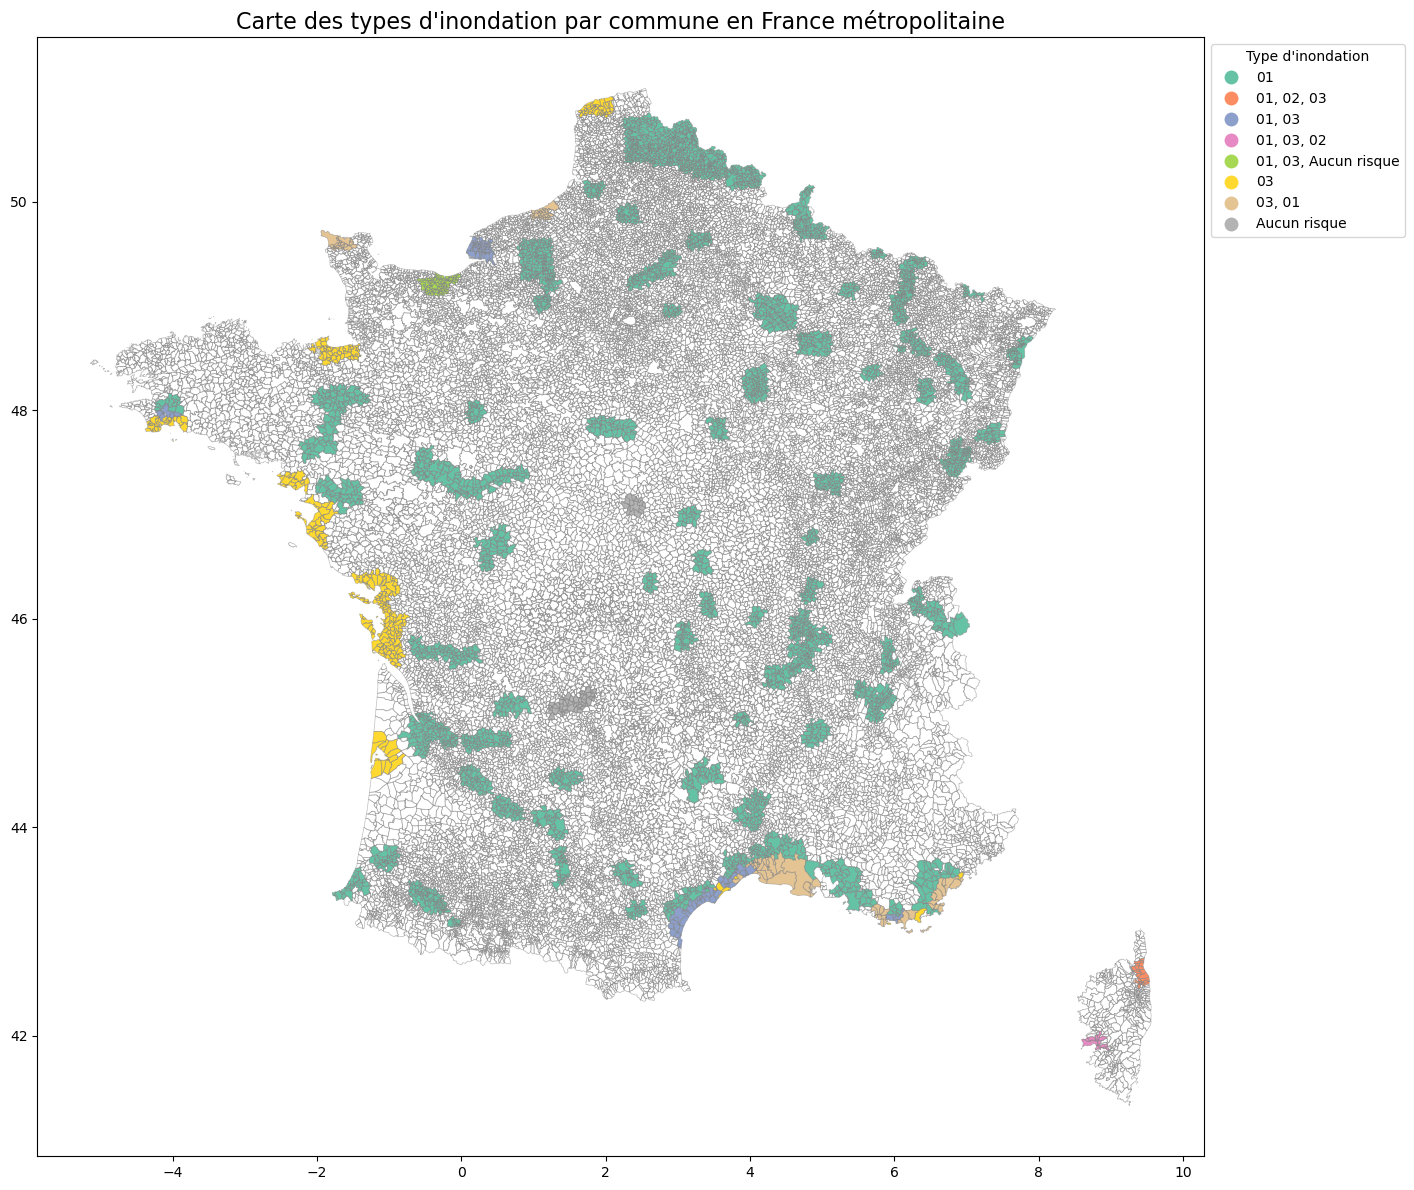

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from cartiflette import carti_download

# Charger les données géographiques du Shapefile
shapefile_path = "Shp file : Zones innondables/n_carte_inond_s.shp"
gdf = gpd.read_file(shapefile_path)

# Reprojeter les géométries en un CRS projeté (ici, EPSG:2154 pour la France)
gdf = gdf.to_crs(epsg=2154)

# Vérification du CRS des deux jeux de données
print("CRS de gdf:", gdf.crs)
france = carti_download(
    values=["France"],
    crs=4326,
    borders="COMMUNE",
    vectorfile_format="geojson",
    simplification=50,
    filter_by="FRANCE_ENTIERE",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)
print("CRS de france:", france.crs)

# Reprojeter 'france' pour qu'il corresponde à celui de 'gdf'
france = france.to_crs(gdf.crs)

# Effectuer une jointure spatiale entre les points du Shapefile et les communes
joined = gpd.sjoin(gdf, france, how="left", predicate="intersects")

# Vérification des résultats de la jointure
print("Premier aperçu de joined:", joined.head())

# Filtrer uniquement les communes de France métropolitaine
# En EPSG:2154, la latitude pour la France Métropolitaine est comprise entre 41 et 51, et la longitude entre -5 et 10.
gdf = gdf[
    (gdf.geometry.centroid.y >= 41) & (gdf.geometry.centroid.y <= 51) &  # Filtrer par latitude
    (gdf.geometry.centroid.x >= -5) & (gdf.geometry.centroid.x <= 10)   # Filtrer par longitude
]

# Remplacer les valeurs nulles dans 'typ_inond1' par "Aucun risque"
joined["typ_inond1"] = joined["typ_inond1"].fillna("Aucun risque")  # Replace NaN with "Aucun risque"

# Agréger les risques pour chaque commune en combinant tous unique risks
joined["typ_inond1"] = joined["typ_inond1"].astype(str)  # Convert to string for categorical handling
commune_risks = joined.groupby("INSEE_COM")["typ_inond1"].apply(lambda x: ', '.join(x.unique())).reset_index()

# Ajouter les risques au fond de carte
france = france.merge(commune_risks, on="INSEE_COM", how="left")

# Créer la carte
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Ajouter les limites des communes
france.boundary.plot(ax=ax, linewidth=0.5, color="gray", alpha=0.5)

# Remplir les communes avec les risques associés (Categorical colormap)
france.plot(
    column="typ_inond1",
    ax=ax,
    legend=True,
    cmap="Set2",  # Utilisation d'une colormap catégorielle
    legend_kwds={
        "title": "Type d'inondation",
        "loc": "upper left",
        "bbox_to_anchor": (1, 1),
    },
)

# Ajouter un titre
ax.set_title("Carte des types d'inondation par commune en France métropolitaine", fontsize=16)

plt.tight_layout()
plt.show()


Voici une première représentation des risques  d'inondation présents sur le territoire métropolitain Français. 

l'échelle de risque des fichiers Shapefile de georisques est construite selon l'échelle suivante : 
- 1 : Risque faible
- 2 : Risque Modéré 
- 3 : Risque fort 

Nous pouvons remarquer de prime abord que les zones à risque fort d'inondation sont concentrées sur les littoraux. 

Dans cette représentation, nous avons conservé l'intégralité des risques présents à l'intérieur d'une commune. 

La prochaine représentation s'intéresse au risque maximal pour chaque points géographiques présent sur la commune : 

/tmp/ipykernel_31289/975786343.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  (gdf.geometry.centroid.y >= 41) & (gdf.geometry.centroid.y <= 51) &  # Filtrer par latitude
/tmp/ipykernel_31289/975786343.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  (gdf.geometry.centroid.x >= -5) & (gdf.geometry.centroid.x <= 10)   # Filtrer par longitude


Valeurs uniques dans 'typ_inond1': [1 3 0 2]


/tmp/ipykernel_31289/975786343.py:66: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  choropleth = france_with_data.plot(


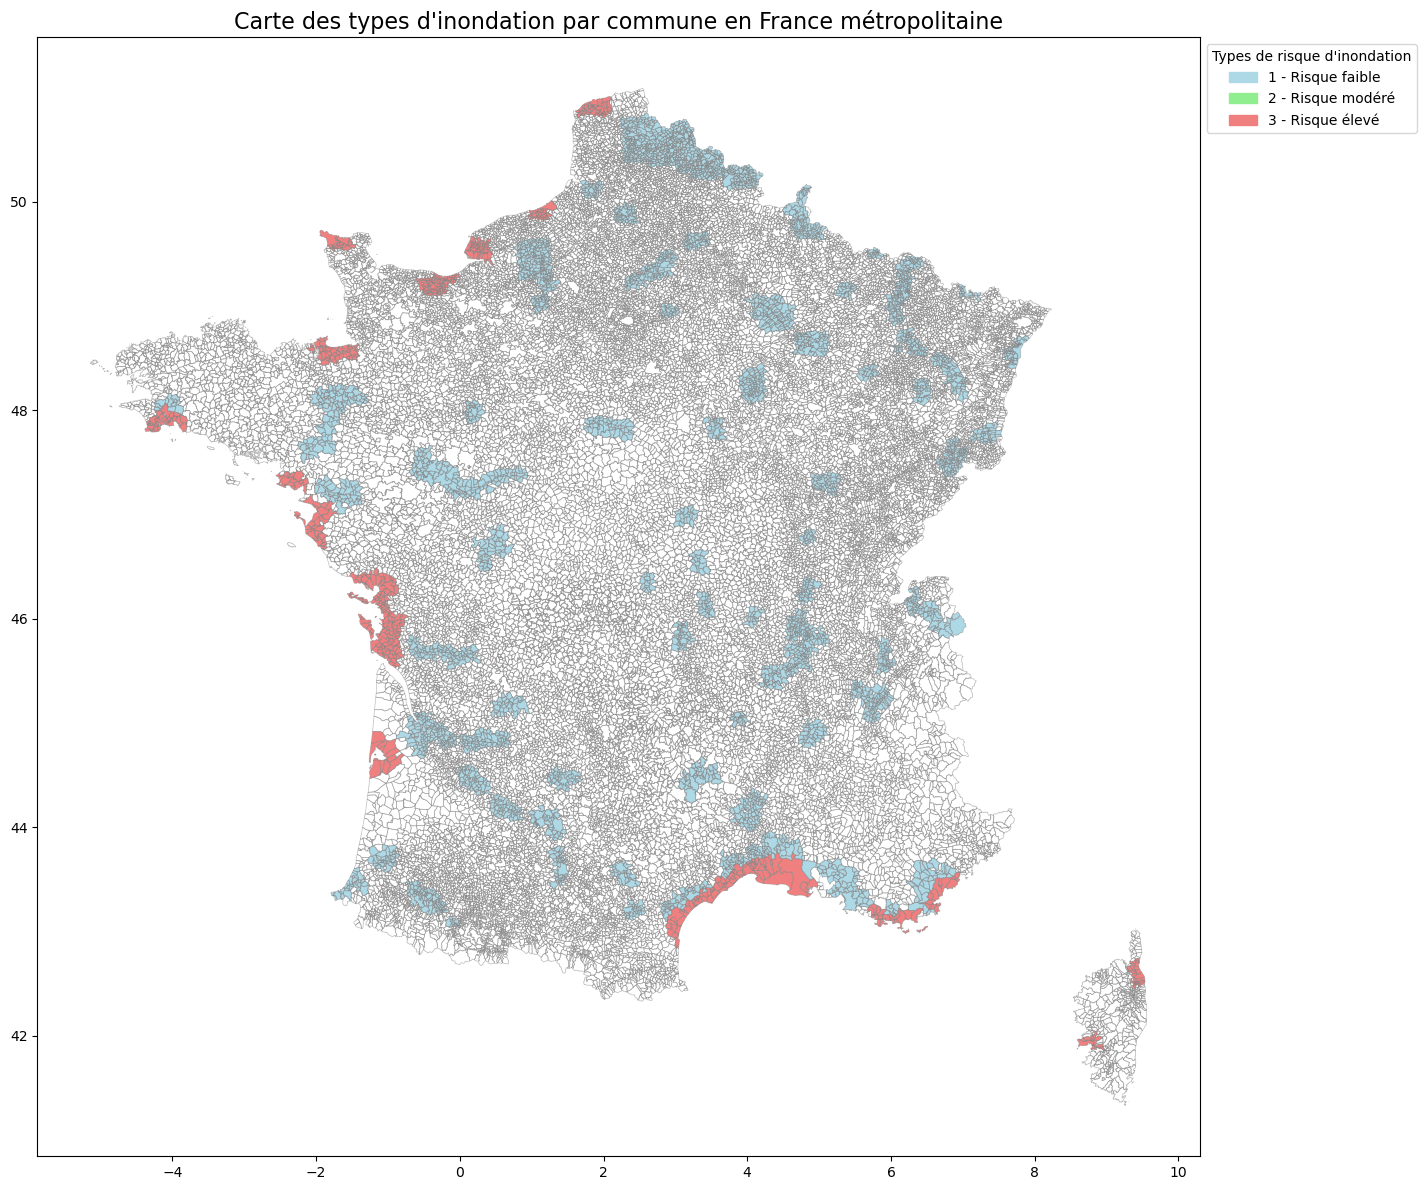

In [7]:
import geopandas as gpd
import matplotlib.pyplot as plt
from cartiflette import carti_download
import matplotlib.patches as mpatches

# Charger les données géographiques du Shapefile
shapefile_path = "Shp file : Zones innondables/n_carte_inond_s.shp"
gdf = gpd.read_file(shapefile_path)

# Filtrer pour garder uniquement les points en France métropolitaine
gdf = gdf[
    (gdf.geometry.centroid.y >= 41) & (gdf.geometry.centroid.y <= 51) &  # Filtrer par latitude
    (gdf.geometry.centroid.x >= -5) & (gdf.geometry.centroid.x <= 10)   # Filtrer par longitude
]

# Télécharger le fond de carte via Cartiflette
france = carti_download(
    values=["France"],
    crs=4326,
    borders="COMMUNE",
    vectorfile_format="geojson",
    simplification=50,
    filter_by="FRANCE_ENTIERE",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)

# Filtrer les communes métropolitaines pour le fond de carte
france = france.loc[france["INSEE_REG"] > 10]

# Vérifier et aligner les CRS
if gdf.crs != france.crs:
    gdf = gdf.to_crs(france.crs)

# Effectuer une jointure spatiale entre les points du Shapefile et les communes
joined = gpd.sjoin(gdf, france, how="left", predicate="intersects")

# Remplacer les valeurs nulles dans 'typ_inond1' par 0 (Aucun risque)
joined["typ_inond1"] = joined["typ_inond1"].fillna(0).astype(int)

# Vérification des valeurs uniques dans 'typ_inond1'
print("Valeurs uniques dans 'typ_inond1':", joined["typ_inond1"].unique())

# Agréger les risques pour chaque commune en combinant tous unique risks
max_risks = joined.groupby("INSEE_COM")["typ_inond1"].max().reset_index()

# Ajouter les risques au fond de carte
france = france.merge(max_risks, on="INSEE_COM", how="left")

# Créer la carte
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Ajouter les limites des communes
france.boundary.plot(ax=ax, linewidth=0.5, color="gray", alpha=0.5)

# Définir une palette de couleurs pour 0, 1, 2 et 3
color_map = {0: None, 1: "lightblue", 2: "lightgreen", 3: "lightcoral"}

# Appliquer les couleurs, et laisser transparent (None) pour les zones sans données
france["color"] = france["typ_inond1"].map(color_map)

# Supprimer les communes sans couleur (pas de données)
france_with_data = france[france["color"].notna()]

# Remplir les communes avec les risques associés
choropleth = france_with_data.plot(
    column="typ_inond1",  # Utiliser les risques d'inondation
    ax=ax,
    color=france_with_data["color"],  # Appliquer la couleur selon la colonne 'color'
    legend=False  # Désactiver la génération automatique de la légende
)

# Ajouter un titre
ax.set_title("Carte des types d'inondation par commune en France métropolitaine", fontsize=16)

# Ajouter manuellement la légende avec matplotlib
legend_labels = ['1 - Risque faible', '2 - Risque modéré', '3 - Risque élevé']
legend_colors = ['lightblue', 'lightgreen', 'lightcoral']

# Créer une légende manuellement avec les couleurs correspondantes
patches = [mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]
ax.legend(handles=patches, title="Types de risque d'inondation", loc='upper left', bbox_to_anchor=(1, 1))

# Ajuster l'espacement et afficher la carte
plt.tight_layout()
plt.show()


Notre intuition concernant la répartition des risques entre littoral et l'intérieur du pays est confortée. 

On Pourrait s'intéresser au croisement entre nature du risque et niveau de risque. 

Nous allons nous concentrer sur une zone où il semblerait y avoir une forte corrélation, d'après le papier de Tristan Ancel et Thierry Kamionka, entre les effets du risque d'inondation et la valeur foncière: le Gard. 
Dans leur article, Les effets du risque d’inondation sur la valeur foncière des maisons en France, Les auteurs mettent en évidence une décote proportionnelle au risque dans le Gard que nous tenterons également à partir de nos jeux de données de mettre en évidence. 


I- Analyse granulaire du risque d'inondation dans le Gard 

Premier aperçu de joined:   typ_inond1 typ_inond2 scenario datfinval           id_tri  \
0         03         03     None       NaT  FRM_TRI_MAYOTTE   
1         02       None    01For       NaT     FRI_TRI_BASS   
2         02       None    01For       NaT     FRI_TRI_BASS   
3         02       None    02Moy       NaT     FRI_TRI_BASS   
4         02       None    02Moy       NaT     FRI_TRI_BASS   

              urlrapport  est_synth   datappro    id_carte    id  ...  \
0  N_MAYO_RISQUES_03.pdf          1 2019-12-16  CSI_030002  9794  ...   
1         non communiqué          0        NaT    CSI_1981  9835  ...   
2         non communiqué          0        NaT    CSI_1982  9836  ...   
3         non communiqué          0        NaT    CSI_1983  9837  ...   
4         non communiqué          0        NaT    CSI_1984  9838  ...   

  TDUU2017  AAV2020 TAAV2017  TDAAV2017 CATEAAV2020 BV2012  \
0      NaN      NaN      NaN        NaN         NaN    NaN   
1      NaN      NaN      NaN    

/tmp/ipykernel_31289/3963292540.py:56: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  france["centroid"] = france.geometry.centroid
/tmp/ipykernel_31289/3963292540.py:71: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  gard.boundary.plot(ax=ax, linewidth=0.5, color="black", alpha=0.5)


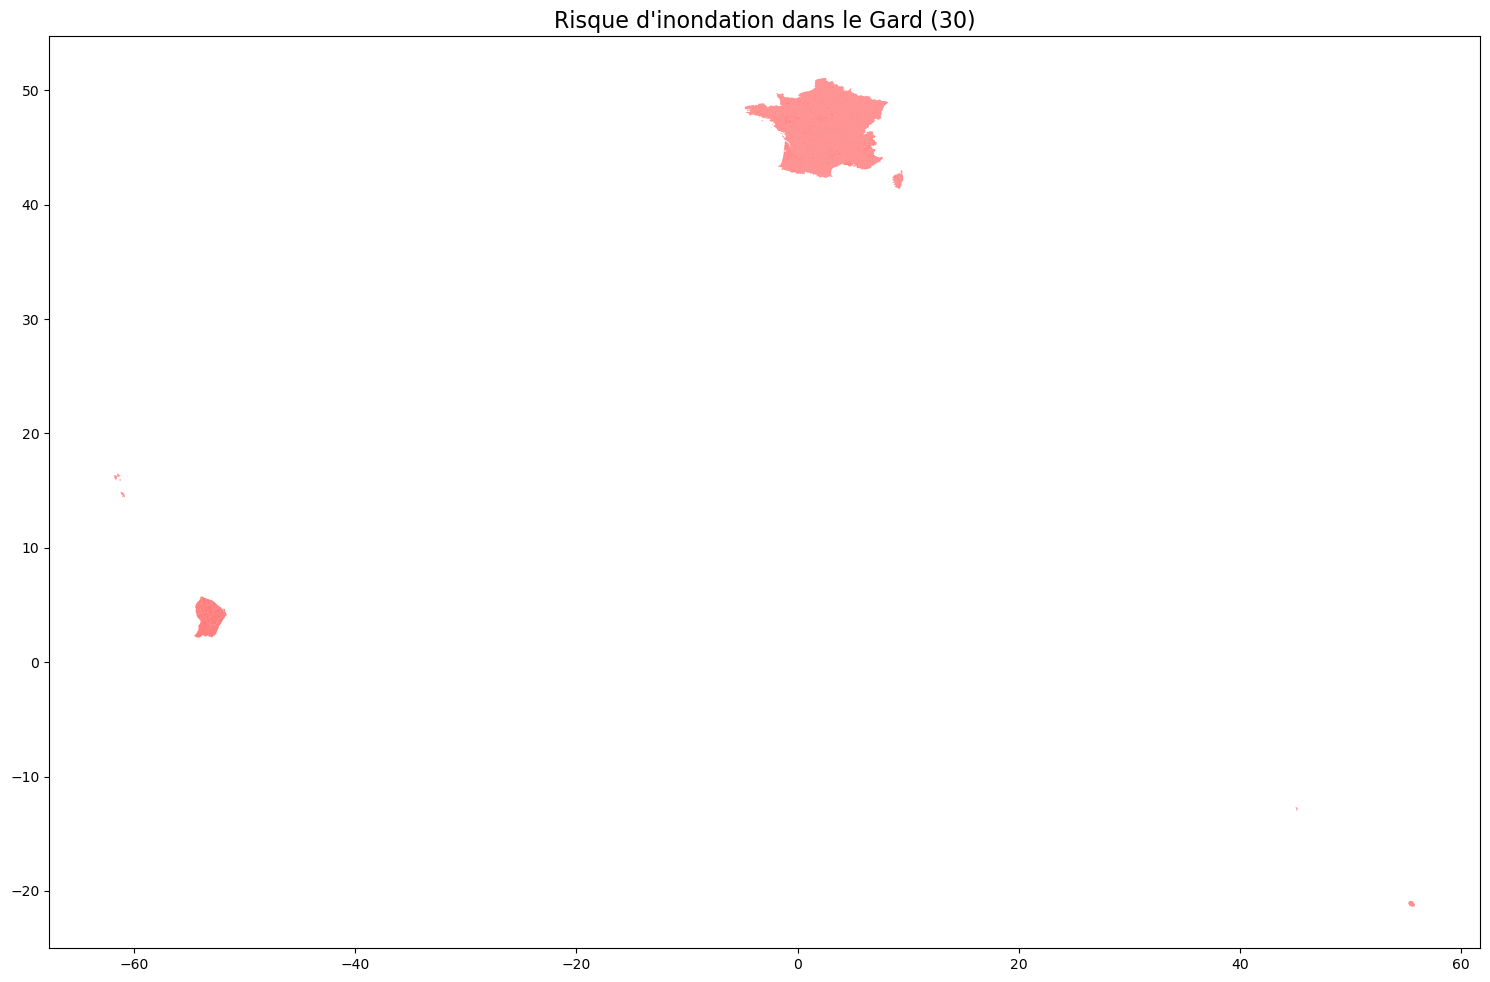

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from cartiflette import carti_download
from sklearn.cluster import DBSCAN
import numpy as np

# Charger les données géographiques du Shapefile
shapefile_path = "Shp file : Zones innondables/n_carte_inond_s.shp"
gdf = gpd.read_file(shapefile_path)

#filtrer gdf pour le Gard

# Reprojeter les géométries en un CRS projeté (ici, EPSG:2154 pour la France)
gdf = gdf.to_crs(epsg=2154)

# Télécharger le fond de carte Cartiflette pour le Gard
france = carti_download(
    values=["France"],
    crs=4326,
    borders="COMMUNE",
    vectorfile_format="geojson",
    simplification=50,
    filter_by="FRANCE_ENTIERE",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)

# Filtrer les communes du Gard (département 30)
gard = france[france["INSEE_REG"] == 30]

# Reprojeter 'france' pour qu'il corresponde à celui de 'gdf'
gard = gard.to_crs(gdf.crs)

# Effectuer une jointure spatiale entre le Shapefile et les communes du Gard
joined = gpd.sjoin(gdf, gard, how="left", predicate="intersects")

# Vérification des résultats de la jointure
print("Premier aperçu de joined:", joined.head())



# Remplacer les valeurs nulles dans 'typ_inond1' par "Aucun risque"
joined["typ_inond1"] = joined["typ_inond1"].fillna("Aucun risque")  # Replace NaN with "Aucun risque"

# Agréger les risques pour chaque commune en combinant tous les risques uniques
joined["typ_inond1"] = joined["typ_inond1"].astype(str)  # Convertir en chaîne pour la gestion catégorielle
commune_risks = joined.groupby("INSEE_COM")["typ_inond1"].apply(lambda x: ', '.join(x.unique())).reset_index()

# Ajouter les risques au fond de carte
france = france.merge(commune_risks, on="INSEE_COM", how="left")

# Calculer les centroids pour les géométries des communes
france["centroid"] = france.geometry.centroid

# Extraire les coordonnées x et y des centroids
coords = np.array(list(zip(france["centroid"].x, france["centroid"].y)))

# Créer les clusters de points de risque d'inondation
db = DBSCAN(eps=1000, min_samples=10).fit(coords)  # ajustez eps et min_samples selon la granularité

# Ajouter les labels des clusters au DataFrame
france["cluster"] = db.labels_

# Créer la carte
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Ajouter les limites des communes du Gard
gard.boundary.plot(ax=ax, linewidth=0.5, color="black", alpha=0.5)

# Afficher les clusters avec des contours rouges
for cluster_id in np.unique(db.labels_):
    cluster_points = france[france["cluster"] == cluster_id]
    if cluster_id != -1:  # Exclure les points non assignés
        cluster_points.plot(ax=ax, marker="o", color="red", alpha=0.5, legend=True)

# Ajouter un titre
ax.set_title("Risque d'inondation dans le Gard (30)", fontsize=16)

plt.tight_layout()
plt.show()


In [16]:
# Télécharger le fond de carte Cartiflette pour le Gard
france = carti_download(
    values=["76"],
    crs=4326,
    borders="COMMUNE",
    vectorfile_format="geojson",
    simplification=50,
    filter_by="FRANCE_ENTIERE",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)

There was an error while reading the file from the URL: https://minio.lab.sspcloud.fr/projet-cartiflette/production/provider=IGN/dataset_family=ADMINEXPRESS/source=EXPRESS-COG-CARTO-TERRITOIRE/year=2022/administrative_level=COMMUNE/crs=4326/FRANCE_ENTIERE=76/vectorfile_format=geojson/territory=metropole/simplification=50/raw.geojson
Error message: HTTP Error 404: Not Found


ValueError: All objects passed were None

In [15]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 0 entries
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   typ_inond1  0 non-null      object        
 1   typ_inond2  0 non-null      object        
 2   scenario    0 non-null      object        
 3   datfinval   0 non-null      datetime64[ms]
 4   id_tri      0 non-null      object        
 5   urlrapport  0 non-null      object        
 6   est_synth   0 non-null      int32         
 7   datappro    0 non-null      datetime64[ms]
 8   id_carte    0 non-null      object        
 9   id          0 non-null      int32         
 10  geometry    0 non-null      geometry      
dtypes: datetime64[ms](2), geometry(1), int32(2), object(6)
memory usage: 0.0+ bytes
